## Newer VAE Methods


> CHBE 413




Group Members: Sumana Dara, Junyuan Miao, Chantal Korde,  Damien Soubassis



# Abstract
The pharmaceutical industry is an industry that has recently been transformed by the advancement of AI and other machine learning (ML) technologies. More specifically, automation and ML have expedited the timeline from drug discovery to the manufacturing of medicine. These models remain quite important even if VAEs sometimes generate blurred or "safe" reconstructions because of the regularizing term in their loss function encouraging the latent space to follow a simple distribution. However, this paper will specifically focus on the application of VAEs and their impact in potentially discovering new molecules using a dataset containing commercially available compounds for virtual screening. The comparison of newer VAE methods such as Junction Tree VAEs and Graph VAEs will also be discussed. Since both VAEs and attention mechanisms concentrate on creating meaningful data representations, these techniques can be considered as complementary to attention-based techniques like those found in Transformers. It was found that through comparing the various VAE methods, the original VAE method produced on average, a 81% accuracy of generating valid molecules through SMILES, while the Junction Tree had a 94% accuracy of generating valid molecule structures without any checks on the Zinc dataset. Furthermore, through multiple research papers Graph VAEs were found to perform better than the original VAE method of using SMILES data.

In [ ]:
pip install torch rdkit

In [ ]:
import torch #importing necessary libraries
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from rdkit import Chem
import matplotlib.pyplot as plt
import torch
from contextlib import redirect_stderr
from io import StringIO
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
torch.manual_seed(42) #setting the random seed to 42
np.random.seed(42)

This code was found on github.

KDDAnonymous (2021):
https://github.com/Users4Submission/KDDAnonymous/blob/b023e3d193bae17e08e4a622b77309cab8b2a8e5/models/VAE_Siamese.py

In [ ]:
class SMILESDataset(Dataset):
    """
    A PyTorch Dataset class for SMILES strings.

    This class provides an interface to handle lists of SMILES strings as a dataset
    compatible with PyTorch Dataloader. Each item in the dataset is a single SMILES string.

    Args:
        smiles_list: A list contains SMILES strings.

    Attributes:
        smiles_list: Stored SMILES data.
    """
    def __init__(self, smiles_list):
        """
        Initializes the SMILESDataset with a list of SMILES strings.

        Args:
            smiles_list: A list contains SMILES strings.
        """
        self.smiles_list = smiles_list

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
            int: the number of SMILES strings in the dataset.
        """
        return len(self.smiles_list)

    def __getitem__(self, idx):
        """
        Retrieves a single SMILES string at the specified index.

        Args:
            idx: The index of the SMILES string to retrieve.

        Returns:
            str: The SMILES string at the given index.
        """
        return self.smiles_list[idx]

class VAE(nn.Module):
    """
    VAE module using Pytorch.

    This class defines simple VAE with a single hidden layer in both the encoderff and decoder.
    The encodere maps inputs to latent parameters,
    and the decoder constructs inputs from the latent space.

    Args:
        input_dim: Dimensionality of the input data.
        hidden_dim: Dimensionality of the hidden layer in both encoder and decoder.
        latent_dim: Dimensionality of the latent representation.

    Attributes:
        latent_dim: Dimensionality of the latent space.
        encoder (nn.Sequential): Encoder network mapping input to latent parameters.
        decoder (nn.Sequential): Decoder network mapping latent space to reconstruted input.
    """
    def __init__(self, input_dim, hidden_dim, latent_dim):
        """
        Initializes the VAE with the given input, hidden, and latent dimensions.

        Args:
            input_dim: Dimension of the input data.
            hidden_dim: Dimension of the hidden layer.
            latent_dim: Dimension of the latent representation.
        """
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # outputs mean and log-variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from a Gaussian distribution using mu and logvar.

        Args:
            mu: Mean of the latent Gaussian.
            logvar: Log-variance of the latent Gaussian.

        Returns:
            torch.Tensor: A sample from the Gaussian distribution parameterized by mu and logvar.
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        """
        Performs a forward pass through the VAE.
        Encodes the input to latent parameters (mu and logvar), samples from the latent distribution,
        and then decodes the sample to reconstruct the input.

        Args:
            x: Input tensor of shape (batch_size, input_dim).

        Returns:
            tuple: A tuple where:
                recon_x: Reconstructed input.
                mu: Mean of the latent distribution.
                logvar: Log-variance of the latent distribution.
        """
        x = x.view(-1, input_dim)
        params = self.encoder(x)
        mu, logvar = params[:, :self.latent_dim], params[:, self.latent_dim:]
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

def loss_function(recon_x, x, mu, logvar):
    """
    Computes the VAE loss, a combination of reconstruction loss and the Kullback-Leibler divergence.
    Args:
        recon_x: Reconstructed input.
        x: Original input.
        mu: Mean of the latent distribution.
        logvar: Log-variance of the latent distribution.

    Returns:
        torch.Tensor: The scalar loss value.
    """
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
# Load the SMILES strings from train, test, and validation files
with open("train.txt", "r") as f:
    train_smiles_list = [line.strip() for line in f.readlines()]

with open("test.txt", "r") as f:
    test_smiles_list = [line.strip() for line in f.readlines()]

with open("valid.txt", "r") as f:
    validation_smiles_list = [line.strip() for line in f.readlines()]

#this is to cut down the data as there is not enough cpu power to use the whole dataset
train_smiles_list = train_smiles_list[:1000]
test_smiles_list = test_smiles_list[:1000]
validation_smiles_list = validation_smiles_list[:1000]

# Calculate the maximum length of a SMILES string across all datasets
max_length = max(max(len(smile) for smile in train_smiles_list),
                 max(len(smile) for smile in test_smiles_list),
                 max(len(smile) for smile in validation_smiles_list))

# Define the list of possible characters for one-hot encoding SMILES
alphabet = list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789@+-/\\[]()=#$.")

# Create a dictionary mapping each character to its index for one-hot encoding
index = {char: i for i, char in enumerate(alphabet)}

# The input dimension is the product of the number of possible characters and the maximum SMILES length
input_dim = len(alphabet) * max_length

# Define the one-hot encoding function
def onehot(smiles, max_length, index):
    """
    Convert a SMILES string into a one-hot encoded tensor.

    Args:
        smiles: The SMILES string to encode.
        max_length: The maximum length of the SMILES string.
        index: A dictionary mapping each character to its corresponding index in the one-hot representation.

    Returns:
        torch.Tensor: A one-dimensional tensor containing the flattened one-hot encoding of the SMILES.
    """
    onehot = torch.zeros(max_length, len(index))
    for i, char in enumerate(smiles):
        if i < max_length and char in index:
            onehot[i, index[char]] = 1
    return onehot.view(-1)

# Convert each SMILES list to one-hot encoded tensors
train_data = [onehot(smiles, max_length, index) for smiles in train_smiles_list]
test_data = [onehot(smiles, max_length, index) for smiles in test_smiles_list]
validation_data = [onehot(smiles, max_length, index) for smiles in validation_smiles_list]

# Create PyTorch datasets for train, test, and validation
train_dataset = SMILESDataset(train_data)
test_dataset = SMILESDataset(test_data)
val_dataset = SMILESDataset(validation_data)

# Create data loaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("Current Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

GPU Available: True
Current Device: Tesla T4


In [ ]:
#GridSeach hyperparameter

from itertools import product
import torch

# Hyperparameters
hidden_dims = [128, 256, 512]
latent_dims = [32, 64, 128]
learning_rates = [0.001, 0.005]
epochs_list = [10, 15, 20]

# Create all possible combinations
param_combinations = list(product(hidden_dims, latent_dims, learning_rates, epochs_list))

# Initialize tracking variables
best_model = None
best_val_loss = float('inf')  # Validation loss determines the best model
best_param = None
train_losses_dict = {}
val_losses_dict = {}

# Perform grid search
for hidden_dim, latent_dim, lr, epochs in param_combinations:
    param = {
        "Hidden_dim": hidden_dim,
        "Latent_dim": latent_dim,
        "lr": lr,
        "epochs": epochs
    }

    print(f"\nTraining with hyperparameters: Hidden_dim={hidden_dim}, Latent_dim={latent_dim}, lr={lr}, epochs={epochs}")

    # Initialize model and optimizer
    model = VAE(input_dim, hidden_dim, latent_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            recon_input, mu, logvar = model(batch.float())
            loss = loss_function(recon_input, batch.float(), mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        avg_train_loss = train_loss / len(train_dataset)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                recon_input_val, mu_val, logvar_val = model(batch.float())
                loss_val = loss_function(recon_input_val, batch.float(), mu_val, logvar_val)
                val_loss += loss_val.item()
        avg_val_loss = val_loss / len(val_dataset)
        val_losses.append(avg_val_loss)

        # Output training and validation loss
        print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Save losses
    train_losses_dict[str(param)] = train_losses
    val_losses_dict[str(param)] = val_losses

    # Determine if this model is the best based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model = model
        best_param = param

# Print best parameters and validation loss
print("\nGrid Search Results:")
print(f"Best parameters: {best_param}")
print(f"Best Validation Loss: {best_val_loss}")


Training with hyperparameters: Hidden_dim=128, Latent_dim=32, lr=0.001, epochs=10
Epoch 1, Training Loss: 4620.2302, Validation Loss: 3152.8413
Epoch 2, Training Loss: 1349.7357, Validation Loss: 423.8690
Epoch 3, Training Loss: 417.7220, Validation Loss: 330.8878
Epoch 4, Training Loss: 276.0159, Validation Loss: 246.0680
Epoch 5, Training Loss: 236.0446, Validation Loss: 228.5109
Epoch 6, Training Loss: 221.1983, Validation Loss: 220.5099
Epoch 7, Training Loss: 213.6468, Validation Loss: 211.4733
Epoch 8, Training Loss: 205.2741, Validation Loss: 206.1897
Epoch 9, Training Loss: 200.5206, Validation Loss: 201.3268
Epoch 10, Training Loss: 196.5810, Validation Loss: 197.6187

Training with hyperparameters: Hidden_dim=128, Latent_dim=32, lr=0.001, epochs=15
Epoch 1, Training Loss: 4589.5768, Validation Loss: 3032.4448
Epoch 2, Training Loss: 1211.1671, Validation Loss: 445.3355
Epoch 3, Training Loss: 416.1245, Validation Loss: 320.7295
Epoch 4, Training Loss: 270.4553, Validation Lo

In [ ]:
#Used to plot figure 4 in the report
def onehot_to_smiles(onehot_vector, index): #defining function to decode one hot encoded to smiles
    index_to_char = {i: char for char, i in index.items()} #creating an inverse map for the inxed to character
    smiles = "" #creating an empty string for the smiles
    onehot_vector = onehot_vector.cpu().detach().numpy() #detaching the vector from computation graph
    for i in range(max_length): #looping through the length of the maximum smile
        segment = onehot_vector[i * len(index):(i + 1) * len(index)] #getting the segment for each singular character
        if len(segment) > 0: #making sure the segment is nonzero
            char_index = np.argmax(segment) #finding the highest value in the segment
            if char_index in index_to_char: #checking if the character exists in the reverse mapping
                smiles += index_to_char[char_index] #appending to the smiles string
        else:
            break  #ending loop if segment is empty
    return smiles #returning the completed smiles
def is_valid_smiles(smiles): #defining a function that checks if the smiles is real
    try:
        mol = Chem.MolFromSmiles(smiles) #checking if the smiles is in the list of real smiles
        return mol is not None #returning the molecule if it is real
    except:
        return False #if it is not real, return false

In [ ]:
#Used to plot figure 4 in the report
sample_sizes = [50, 100, 150, 200, 250, 300,350,400,450,500,550,600,650,700,750] #creating a list of sample sizes to test
valid_proportions = []  #list to store the proportions of real smiles
for num_samples in sample_sizes: #looping through the list of sample sizes
    latent_dim = 128  #latent dimensions in the VAE
    sampled_z = torch.randn(num_samples, latent_dim) #sampling random new points in the latent space
    model.eval() #evaluating the model
    with torch.no_grad():
        generated = model.decoder(sampled_z).view(-1, max_length, len(index)) #decoding the points from the latent space to one hot encoded
    new_smiles = [] #creating an empty list to hold new generated smiles
    valid_smiles_count = 0 #starting the valid smiles count at zero
    with redirect_stderr(StringIO()):
        for g in generated: #looping through the list of generated one hot encoded
            smiles = onehot_to_smiles(g, index) #putting the one hot encoded through to smiles function
            if is_valid_smiles(smiles): #checking if the smiles created is valid
                valid_smiles_count += 1 #increasting the count by one if it is real
            new_smiles.append(smiles) #appending the decoded smiles
    proportion = valid_smiles_count / num_samples #calculating the proportion of real over total smiles
    valid_proportions.append(proportion) #adding the proportion to a list

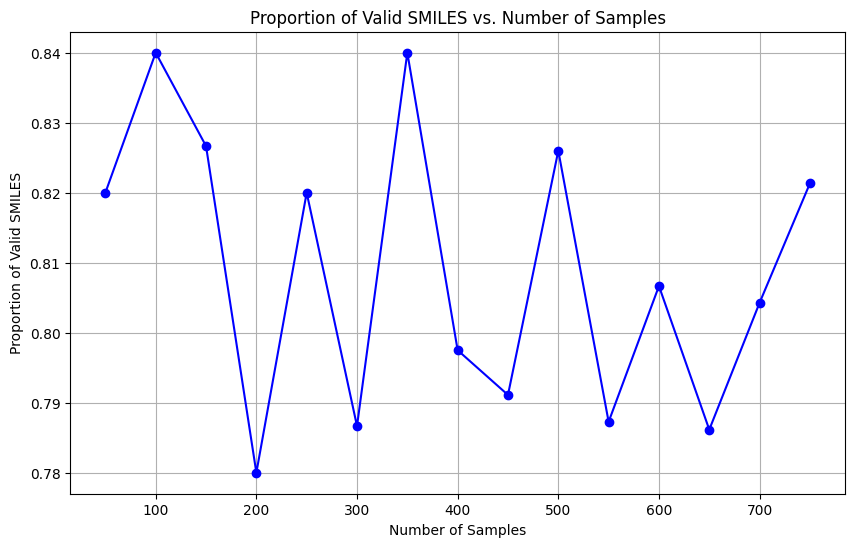

In [ ]:
#Used to plot figure 4 in the report
plt.figure(figsize=(10, 6)) #setting figure size
plt.plot(sample_sizes, valid_proportions, marker='o', linestyle='-', color='b') #adding data to the graph
plt.xlabel('Number of Samples') #labeling the x axis
plt.ylabel('Proportion of Valid SMILES') #labeling the y axis
plt.title('Proportion of Valid SMILES vs. Number of Samples') #titling the graph
plt.grid(True) #showing the graph grid
plt.show() #showing the plot


In [ ]:
np.mean(valid_proportions) #printing the average valid smile proportion

0.8089104488104488

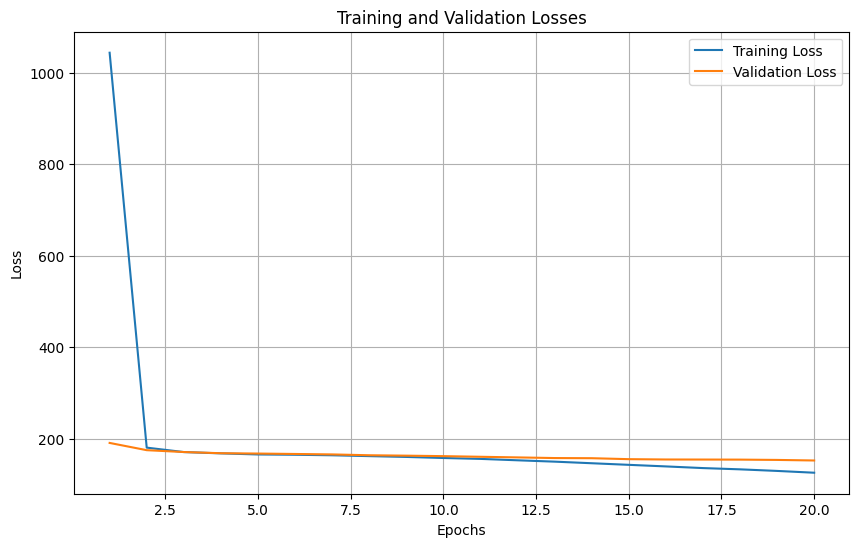

In [ ]:
#The optimal model we found through gridseachCV, which we used to plot the Figure 3 in the code portion of the report
import matplotlib.pyplot as plt
import torch
# Define the best hyperparameters
best_hidden_dim = 512
best_latent_dim = 32
best_lr = 0.005
best_epochs = 20

# Initialize the model and optimizer with the best hyperparameters
model = VAE(input_dim, best_hidden_dim, best_latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)

# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

# Training loop with the best hyperparameters
for epoch in range(best_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        recon_input, mu, logvar = model(batch.float())
        loss = loss_function(recon_input, batch.float(), mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_train_loss = train_loss / len(train_dataset)
    train_losses.append(avg_train_loss)
    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            recon_input_val, mu_val, logvar_val = model(batch.float())
            loss_val = loss_function(recon_input_val, batch.float(), mu_val, logvar_val)
            val_loss += loss_val.item()
    avg_val_loss = val_loss / len(val_dataset)
    val_losses.append(avg_val_loss)
# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, best_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, best_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.legend()
plt.grid()
plt.show()